In [237]:
import pandas as pd
import statsmodels.api as sm
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline
from xgboost import plot_tree
from matplotlib.pylab import rcParams
from sklearn import tree
import os

data_path='c:\\Users\\seyma\\personal_work\\sanofi\\Sanofi_Challenge\\Data\\'

In [238]:
data=pd.read_csv(data_path+"final_df.csv")
data

,output_id,QUANTITY,azot_sec,lod,lla_tel,lla_sec,xa_dry,xa_tel,PH,absorbance,ratio_xa_lla(sec),adn_weighted,lod_weighted,PH_weighted,coag_dry_weighted,YIELD_VALUE
0,122812P10449,232.10,2.052578,2.6,183.0,190.721649,196.098563,196.0,6.90,0.03300,1.005155,1.590833,1.998518,6.918765,180.029381,1.092185
1,122813P10449,253.55,2.106415,2.6,187.0,188.391039,196.098563,191.0,6.60,0.05620,1.011111,1.057432,3.132995,6.959613,168.953098,1.065421
2,122825P10449,265.10,2.100000,3.2,183.0,190.721649,196.098563,196.0,6.90,0.03300,1.005155,0.971856,2.547256,6.912524,177.366063,1.094054
3,121843P10449,223.90,2.131902,2.7,192.0,183.013145,190.816327,194.0,6.60,0.06100,1.066298,0.742307,2.264157,6.935205,178.335101,1.082375
4,121823P10450,227.20,2.131902,2.3,183.0,186.544343,196.098563,183.0,6.72,0.05580,1.000000,1.167632,2.579613,6.939433,175.203956,1.112719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,121827P10449,233.00,2.052578,2.5,183.0,190.721649,192.783505,192.0,6.87,0.06892,1.066298,1.411217,2.310562,6.911807,174.369532,1.088523
92,122826P10449,225.70,2.052578,2.5,187.0,189.847716,195.272354,187.0,6.72,0.06066,1.066298,1.260885,2.308404,6.957182,172.831156,1.124211
93,122821P10449,270.60,2.052578,2.6,187.0,184.917355,192.229039,192.0,6.87,0.06100,1.005102,0.948015,2.617961,6.920396,166.431553,1.094243
94,122819P10449,236.90,2.052578,2.5,187.0,184.917355,192.229039,192.0,6.87,0.06100,1.066298,1.282221,2.007113,6.911070,175.074612,1.063160


In [239]:
data.columns

Index(['output_id', 'QUANTITY', 'azot_sec', 'lod', 'lla_tel', 'lla_sec',
       'xa_dry', 'xa_tel', 'PH', 'absorbance', 'ratio_xa_lla(sec)',
       'adn_weighted', 'lod_weighted', 'PH_weighted', 'coag_dry_weighted',
       'YIELD_VALUE'],
      dtype='object')

 A mixed-effects model, also known as a hierarchical linear model or a random-effects model, is a statistical model that combines fixed effects (systematic effects) and random effects (hierarchical effects). In my case, the fixed effects correspond to the properties of the output materials that directly influence the yield, while the random effects capture the influence of the parent materials on the yield.

I Formulated the mixed-effects model that includes both the fixed effects and random effects. The model equation may look similar to the following:

Yield = β0 + β1 * Property1 + β2 * Property2 + ... + γ1 * ParentMaterial1 + γ2 * ParentMaterial2 + ...

In this equation, β0, β1, β2, ... represent the fixed-effect coefficients corresponding to the output material properties, while γ1, γ2, ... represent the random-effect coefficients corresponding to the parent materials.

MixedLM

In [240]:
# Split the data into train and test sets
X = data[['azot_sec', 'lod', 'lla_tel', 'lla_sec', 'xa_dry', 'xa_tel', 'PH', 'absorbance', 'adn_weighted', 'lod_weighted', 'PH_weighted', 'coag_dry_weighted']]
y = data['YIELD_VALUE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a mixed-effects model using the 'MixedLM' class from statsmodels
model_formula = "YIELD_VALUE ~ azot_sec + lod + lla_tel + lla_sec + xa_dry + xa_tel + PH + absorbance + adn_weighted + lod_weighted + PH_weighted + coag_dry_weighted"
groups = X_train[['azot_sec', 'lod', 'lla_tel', 'lla_sec', 'xa_dry', 'xa_tel', 'PH', 'absorbance']]
groups = groups.apply(tuple, axis=1)  # Convert DataFrame to Series of tuples
model_data = X_train.copy()
model_data['YIELD_VALUE'] = y_train  # Add target variable to the model data
model = sm.MixedLM.from_formula(model_formula, data=model_data, groups=groups)

# Fit the model
result = model.fit()

# Make predictions on the test set
X_test_model = X_test.copy()
X_test_model['YIELD_VALUE'] = 0  # Add a placeholder column for the target variable
y_pred = result.predict(X_test_model)

# Calculate test metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the model summary and test metrics
print(result.summary())
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared Score:", r2)


           Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  YIELD_VALUE
No. Observations:  76       Method:              REML       
No. Groups:        59       Scale:               0.0218     
Min. group size:   1        Log-Likelihood:      11.2593    
Max. group size:   5        Converged:           Yes        
Mean group size:   1.3                                      
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept          2.980    2.889  1.032 0.302 -2.682  8.641
azot_sec          -0.418    0.541 -0.772 0.440 -1.479  0.643
lod               -0.009    0.042 -0.222 0.825 -0.091  0.073
lla_tel            0.007    0.005  1.346 0.178 -0.003  0.017
lla_sec            0.011    0.006  1.753 0.080 -0.001  0.023
xa_dry             0.007    0.004  1.541 0.123 -0.002  0.015
xa_tel            -0.001    0.004 -0

C:\Users\seyma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\seyma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\seyma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


XGBoost

In [241]:
# Split the data into features (X) and target variable (y)
X = data.drop(['YIELD_VALUE', 'output_id'], axis=1)
y = data['YIELD_VALUE']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the XGBoost regression model
model = xgb.XGBRegressor()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared Score:", r2)


Mean Squared Error: 0.002627305173815005
Mean Absolute Error: 0.03891457478930359
R-squared Score: 0.8794843101154103


In [242]:
# os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin' 
# xgb.plot_tree(model, num_trees=10,figsize=(50, 50))
# #plt.show()

<AxesSubplot:>

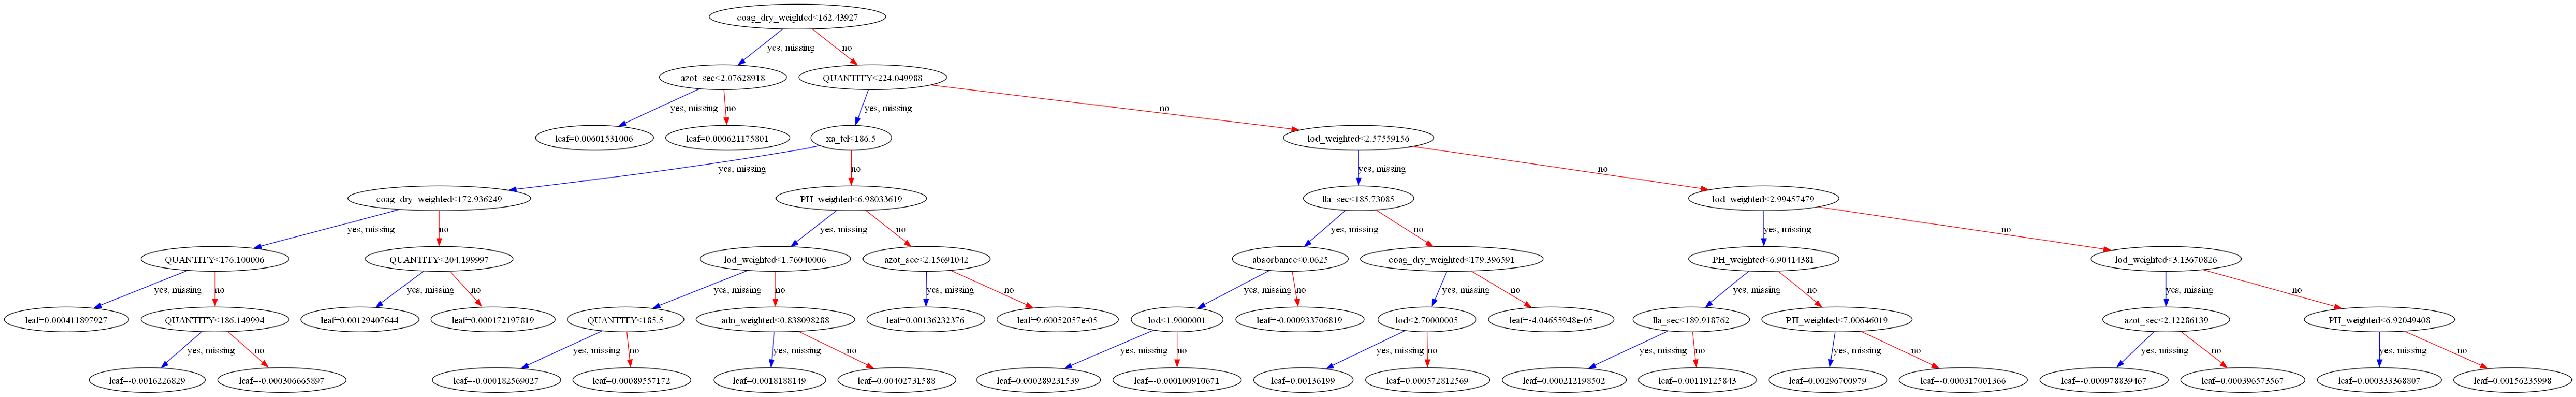

In [243]:
rcParams['figure.figsize'] = 200,100

plot_tree(model, num_trees=15)

In [244]:
plt.rcParams.update(plt.rcParamsDefault)

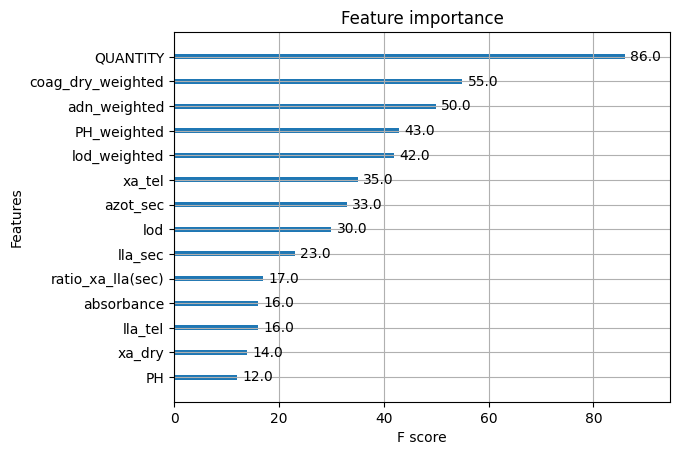

In [245]:
plot_importance(model)
plt.show()


Random Forest

In [246]:
# Create a Random Forest model
model = RandomForestRegressor()

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared Score:", r2)

Mean Squared Error: 0.0021643405846243835
Mean Absolute Error: 0.03772994850349988
R-squared Score: 0.9007207075520379


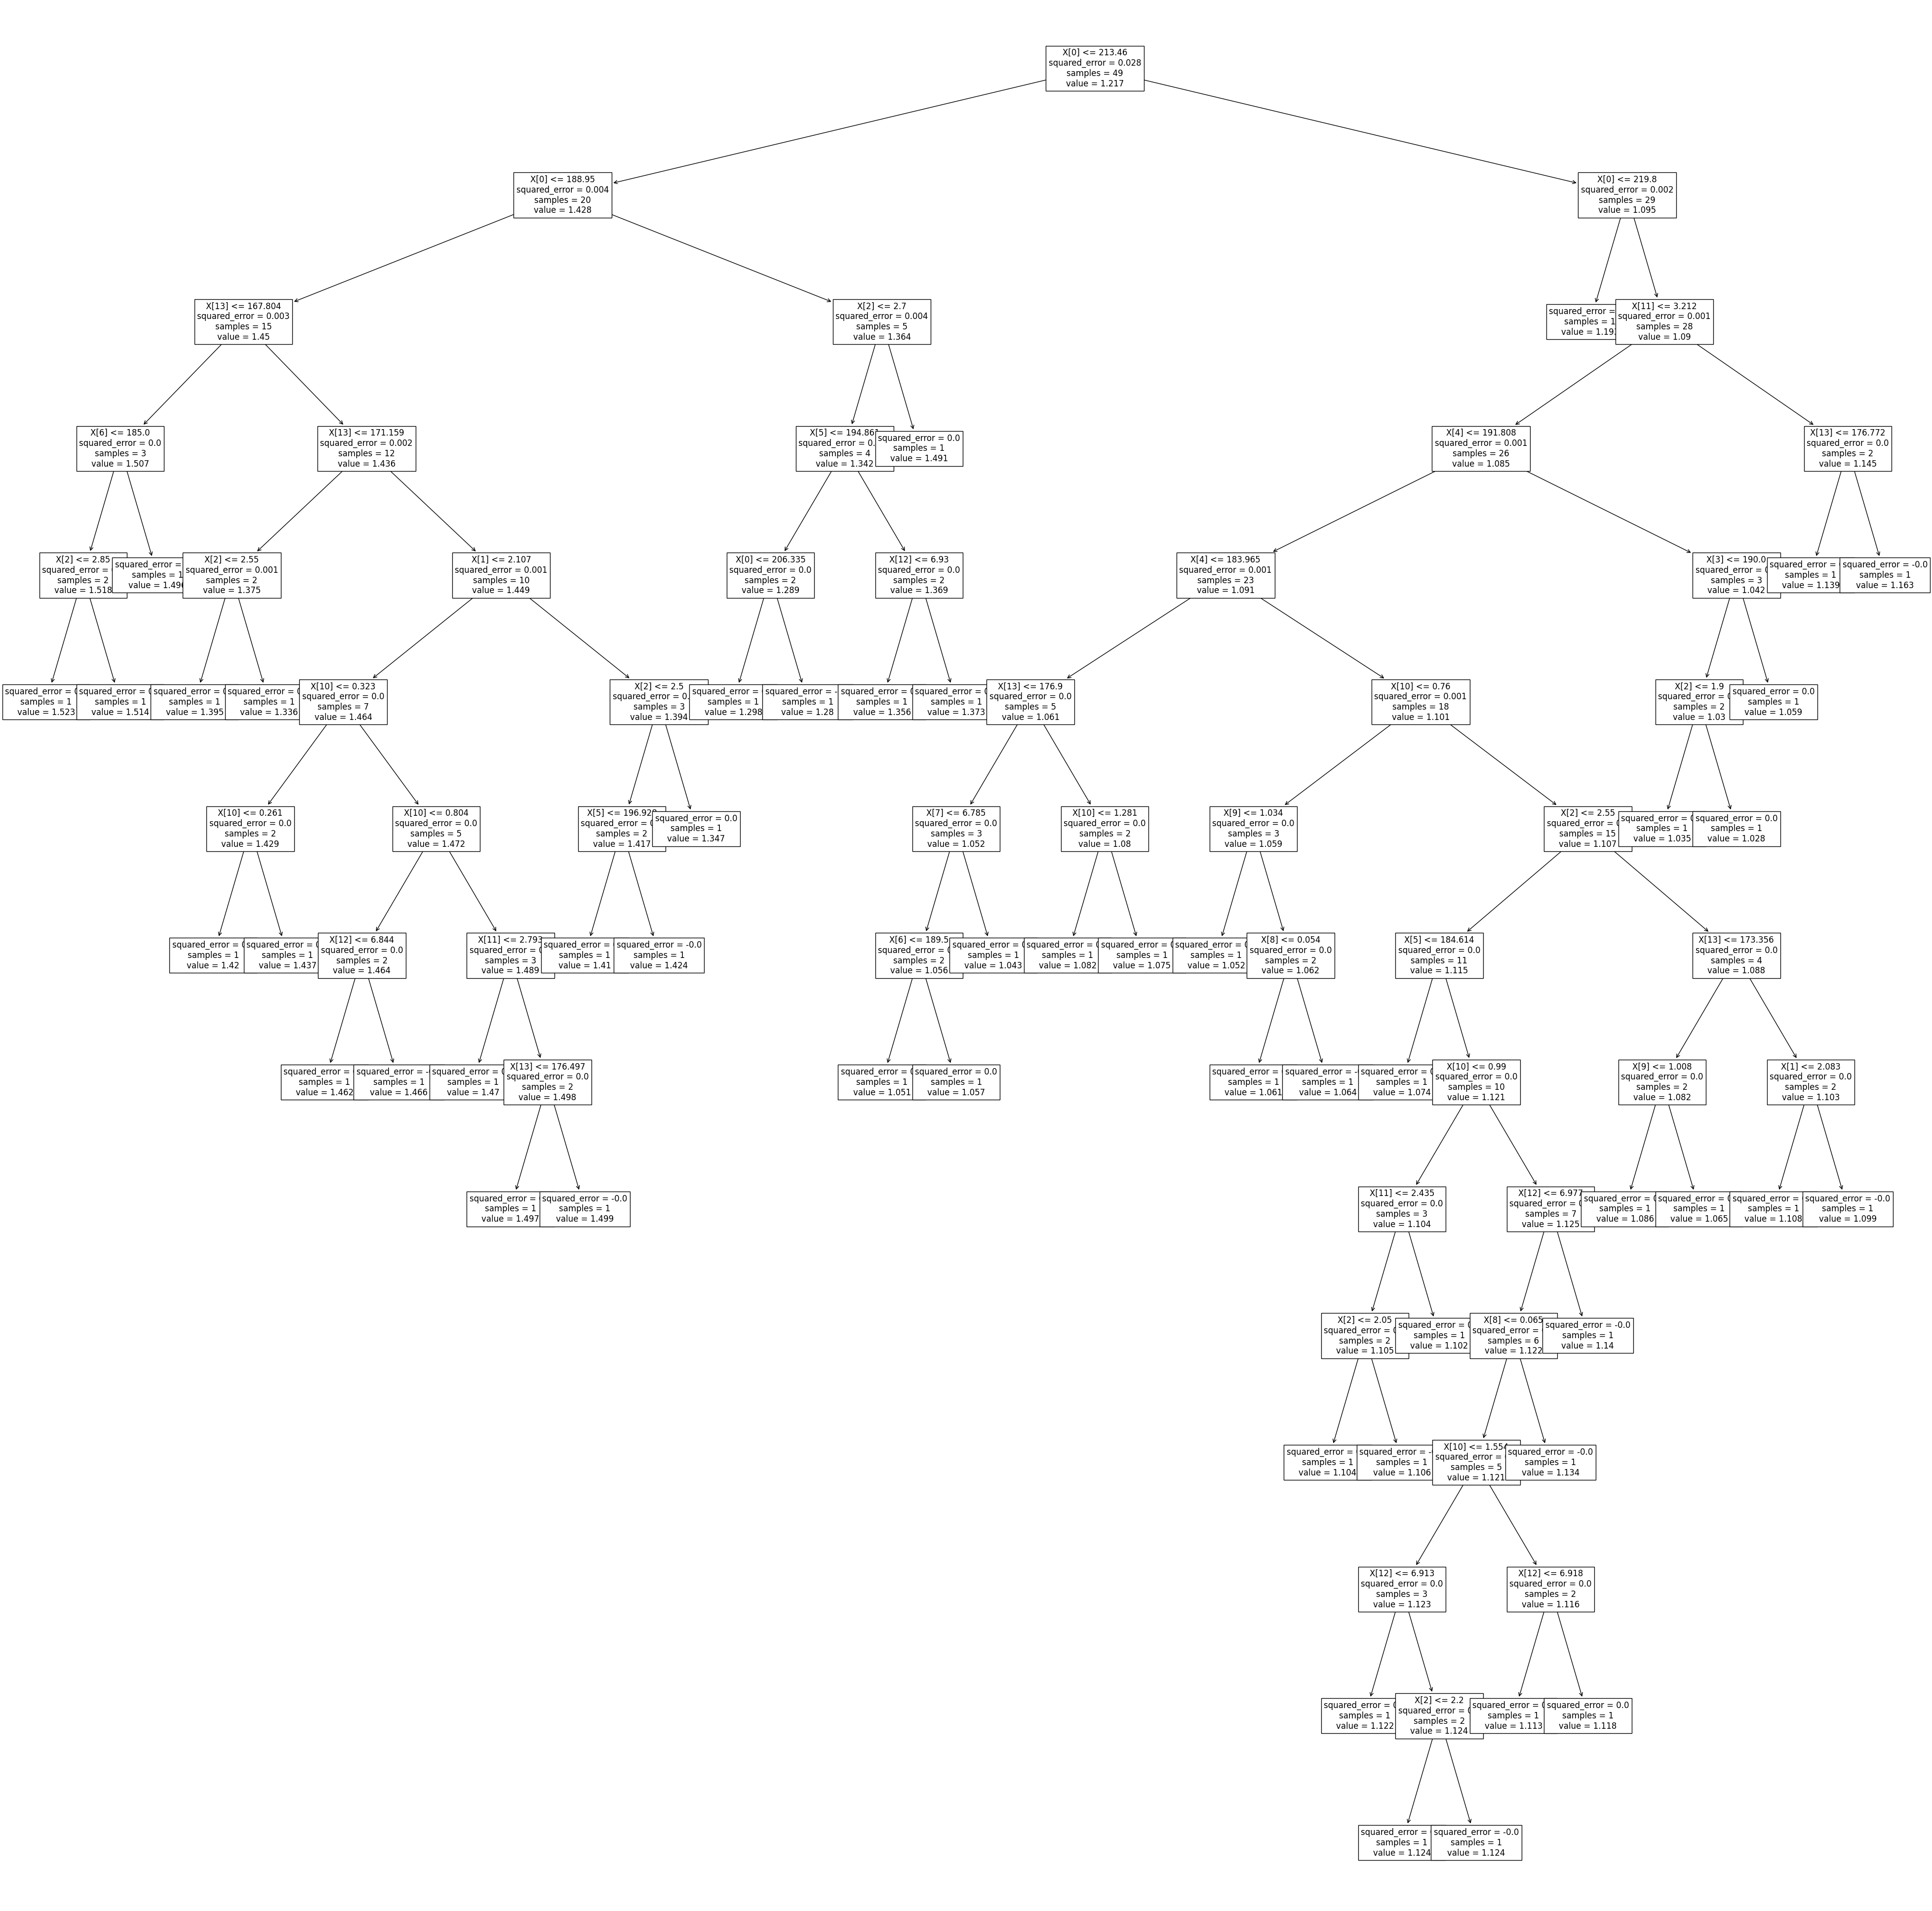

In [247]:
estimator = model.estimators_[0]  # Choose one of the decision trees
fig, ax = plt.subplots(figsize=(50, 50))
tree.plot_tree(estimator, ax=ax,fontsize=12)
plt.show()


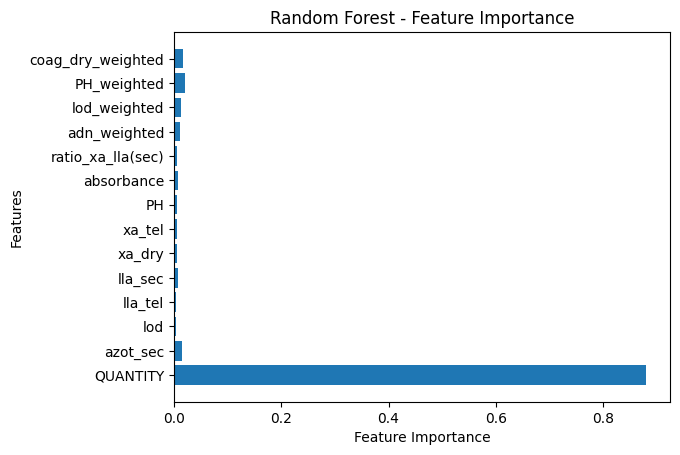

In [248]:
importances = model.feature_importances_
feature_names = X.columns
plt.barh(feature_names, importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Random Forest - Feature Importance')
plt.show()


 Gradient Boosting

In [249]:
# Create a Gradient Boosting model
model = GradientBoostingRegressor()

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared Score:", r2)

Mean Squared Error: 0.0018445528005332993
Mean Absolute Error: 0.034433737143563924
R-squared Score: 0.9153895194588175


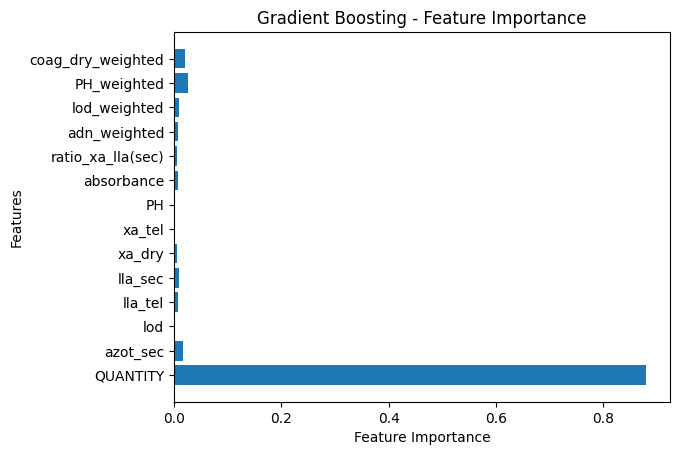

In [250]:
# Plotting feature importance
importances = model.feature_importances_
feature_names = X.columns
plt.barh(feature_names, importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Gradient Boosting - Feature Importance')
plt.show()

Support Vector Machines (SVM)

In [251]:
# Create an SVM model
model = SVR()

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared Score:", r2)

Mean Squared Error: 0.005407334871249962
Mean Absolute Error: 0.060793634256978576
R-squared Score: 0.7519630764859242


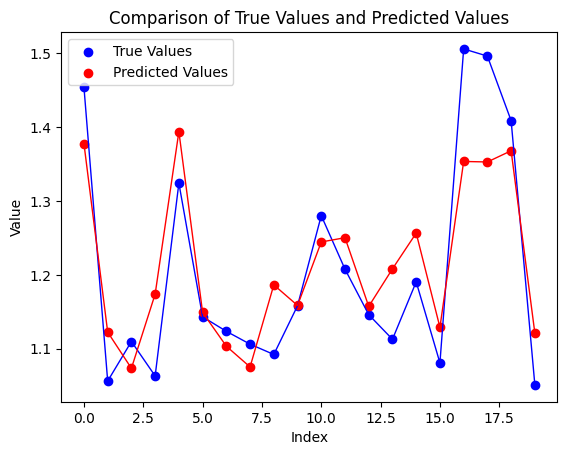

In [252]:
# Scatter plot of y_test in blue
plt.scatter(range(len(y_test)), y_test, color='blue', label='True Values')

# Scatter plot of y_pred in red
plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicted Values')

# Connect the scatter plot points with lines
plt.plot(range(len(y_test)), y_test, color='blue', linestyle='-', linewidth=1)
plt.plot(range(len(y_pred)), y_pred, color='red', linestyle='-', linewidth=1)

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Comparison of True Values and Predicted Values')
plt.legend()
plt.show()
